In [1]:
import sys  
sys.path.insert(0, "/".join(sys.path[0].split("/")[0:-2])+('/src'))
from sisal.solver import Solver
from sisal.utils import normalize_train_test_full_loader,normalize_train_test_full_loader_given_index
from sisal.plot import Plot
from sisal.kernel_adapted import kernel_adapated, plot_kernel_adapted
import numpy as np
from pathlib import Path
from load_data import load
import argparse
import random
import torch
import matplotlib.pyplot as plt

In [2]:
data_dir = Path(r"../../data/VAN0046-LK-3-45-IMS_lipids_neg_roi=#1_mz=fix")
centroids, mask, mask_to_name, pixel_index,mzs = load(data_dir)

print('centroids = ',centroids.shape)
print('mask : ', mask.shape)
print('unique mask : ', np.unique(mask))

centroids =  (237642, 212)
mask :  (237642,)
unique mask :  [0. 1. 2. 3. 4. 5.]


In [3]:
train_loader, test_loader, full_index_loader = normalize_train_test_full_loader_given_index(centroids,pixel_index,mask,batch_size=32)

In [4]:
PATH = 'model_kidney.pth'

In [5]:
args = argparse.Namespace(
    beta=4, 
    z_dim=2, 
    epochs=40,
    device ='cpu',
    save_model_epochs=False,
    save_loss = False,
    train=True)
in_size = centroids.shape[1]

In [6]:
# For reproducibility 

# Set a fixed seed
seed = 6375
seed = 2307
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Reproducibility across GPUs

# Deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
net = Solver(args,in_size)

In [8]:
net.train(train_loader, test_loader,PATH) 

### before epochs
EPOCH 1:
  batch 1000 loss: 88.45096231842041
  batch 2000 loss: 81.65224187469482
  batch 3000 loss: 80.807824508667
  batch 4000 loss: 80.39355135345458
  batch 5000 loss: 80.2861567993164
LOSS train 80.2861567993164 valid 78.52046685010095
----------------Saving Model Epoch 1
EPOCH 2:
  batch 1000 loss: 79.70519511413575
  batch 2000 loss: 78.96362673187255
  batch 3000 loss: 78.998416305542
  batch 4000 loss: 78.8787310333252
  batch 5000 loss: 78.848120552063
LOSS train 78.848120552063 valid 77.20936287003335
----------------Saving Model Epoch 2
EPOCH 3:
  batch 1000 loss: 78.4721833267212
  batch 2000 loss: 77.79036534118653
  batch 3000 loss: 77.81228162002563
  batch 4000 loss: 77.67618563079834
  batch 5000 loss: 77.8083044242859
LOSS train 77.8083044242859 valid 76.5871480768377
----------------Saving Model Epoch 3
EPOCH 4:
  batch 1000 loss: 77.65994406127929
  batch 2000 loss: 77.08083460998535
  batch 3000 loss: 77.20363227844238
  batch 4000 loss: 77.156

'model_kidney.pth'

## Plot

In [7]:
p = Plot(PATH,args.device,train_loader,test_loader,full_index_loader)
## Remove unlabeled pixels
mask0 = p.label!=0
p.full_latent = p.full_latent[mask0,:]
p.vars = p.vars[mask0,:]
p.label = p.label[mask0]

Compute Latent


In [8]:
p.full_latent.shape
p.vars.shape
p.label.shape

(50589,)

Using 20235 samples


/Users/pdelacour/Documents/PL_Ecole/sisal/src/sisal/plot.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x = full_latent[mask,0], y= full_latent[mask,1] ,s =0.01 ,alpha=0.8, c = col_dict[i], label = mask_to_name[i] )


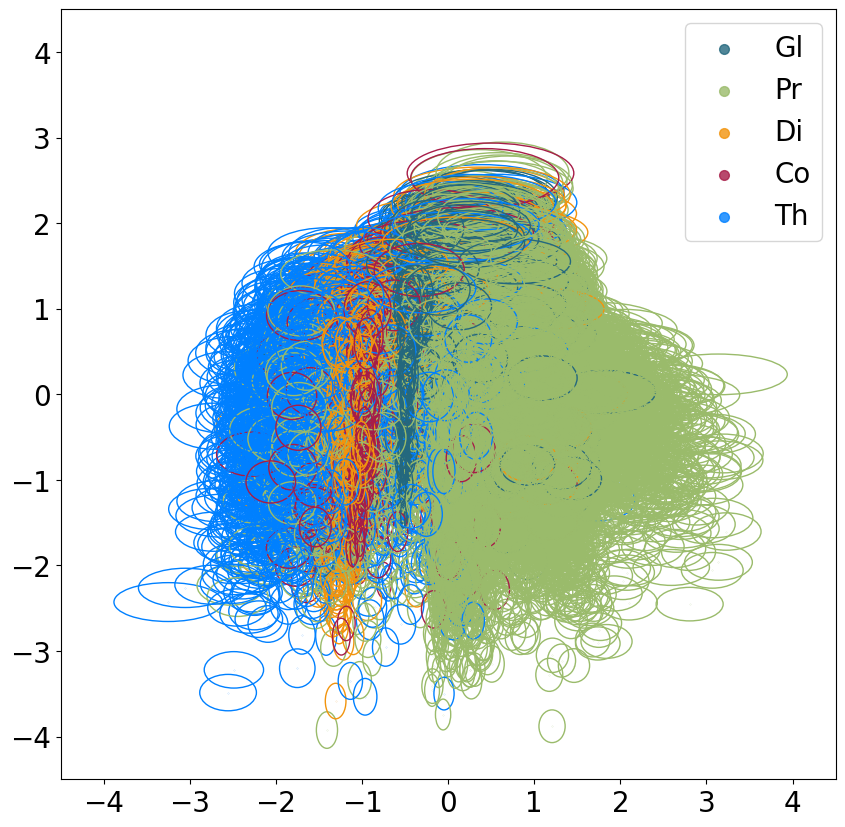

In [8]:
p.plot_latent_dim_with_var(mask_to_name,p=0.4)

## Kernel Density estimation : 

In [9]:
from load_data import index_to_image_pos,load_image_info
import matplotlib.colors as colors_mat

In [10]:
_, image_shape, _ = load_image_info(data_dir)
index_to_image_pos = index_to_image_pos(data_dir)

0
1


Text(0.5, -0.5, 'New Generated Masks')

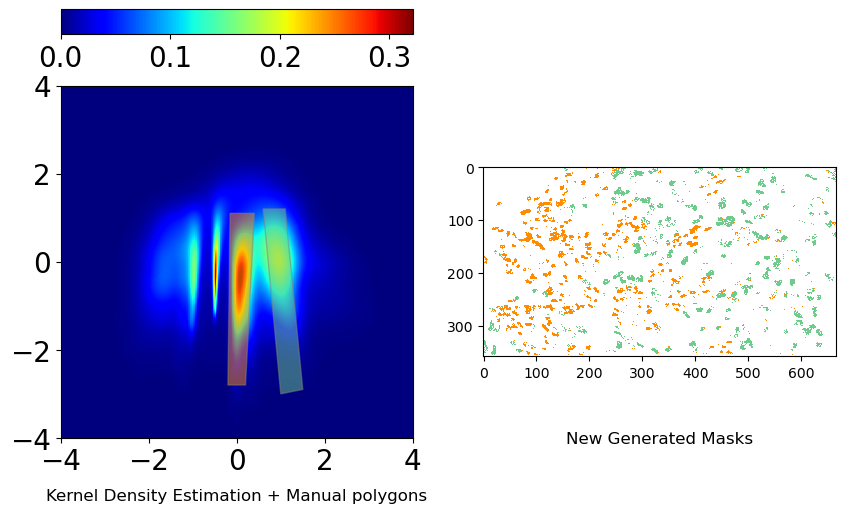

In [11]:
#plot_carving_separate
fig, axs = plt.subplots(figsize=(10,5),ncols=2)
#Left image
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].set_title('Kernel Density Estimation + Manual polygons',y=-0.2)
image = kernel_adapated(p.full_latent,p.vars)
plot_kernel_adapted(axs[0],fig,image)

pol_limit1 = [(-0.2,-2.8),(0.2,-2.8),(0.4,1.1),(-0.15,1.1)] #Orange
pol_limit2= [(1,-3),(1.5,-2.9),(1.1,1.2),(0.6,1.2),] #
pol_limits = [pol_limit1,pol_limit2]
names = ['pr1','pr2']
colors = ['darkorange', "#6DCC8C",] # 'black','#a30000','#f44e97','#6a329f']
masks = p.plot_polygons_get_mask(axs[0],pol_limits,colors,index_to_image_pos,image_shape)

#Right image (masks)
cmap_col = colors_mat.ListedColormap(['white']+colors)
axs[1].imshow(masks,cmap_col,interpolation='none')
axs[1].set_title('New Generated Masks',y=-0.5)

## Latent traversal subdivision

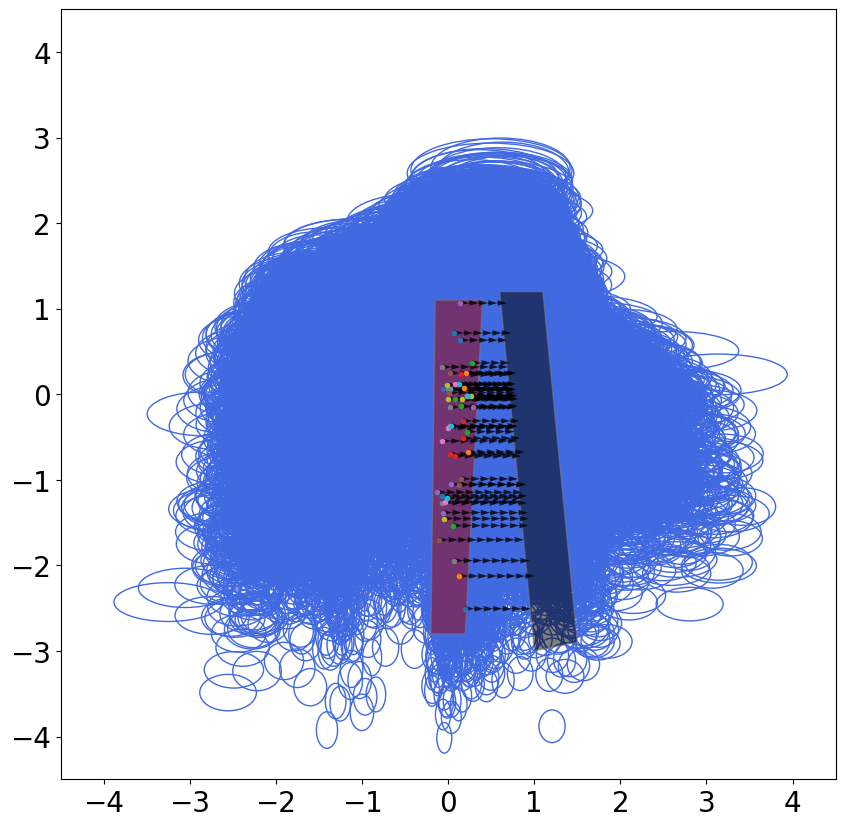

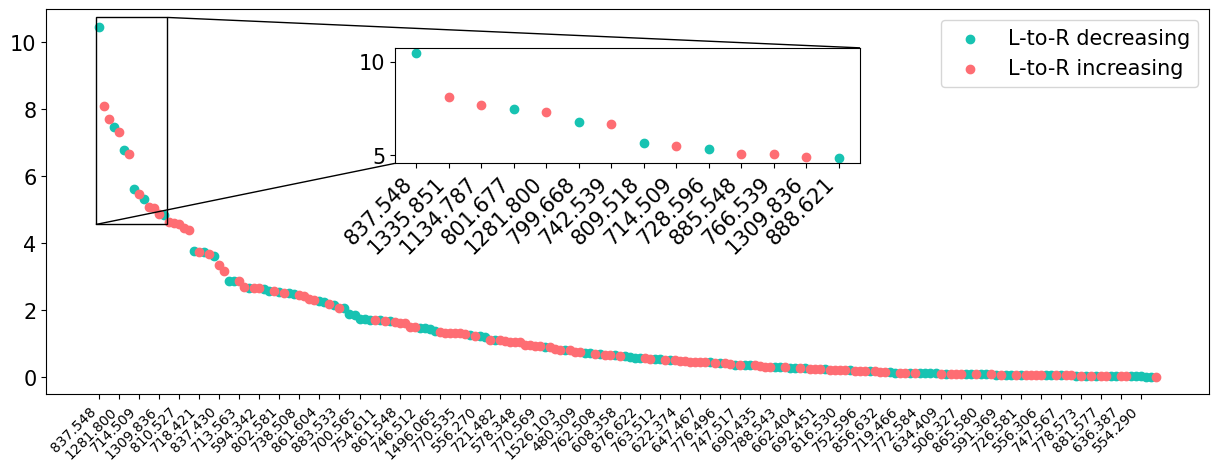

In [ ]:
all_points = p.latent_traversal_legs(mask_to_name,pol_limits[0],pol_limits[1])
p.variance_latent_traversal(all_points, mzs,d=centroids.shape[1])